## 필요한 library import & 파일 불러오기

In [216]:
%matplotlib inline

import cv2
import numpy as np
import math
from matplotlib import pyplot as plt

In [217]:
img = cv2.imread(r"original images\06216A49.jpg") # original image
img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGB)

imgX, imgY, imgC = img.shape

f = open(r"key points\06216A49.txt", 'r') # key points
keyPoints = []

lines = f.readlines() # read key points file
for line in lines:
    line = list(np.float_(line.strip().split(' ')))
    keyPoints.append(line)

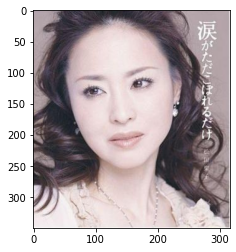

In [218]:
plt.imshow(img)
plt.show()

## Face marker

주의: index는 1부터 시작하므로 실 코드에서는 -1을 해주어야 합니다.

순서대로


**왼쪽눈** 20 21 22 23 24 25

**오른쪽눈** 26 27 28 29 30 31

**입** 32 33 34 35 36 37 38 39 40 41 42 43

In [6]:
def makeList(numList):
    temp = []
    for num in numList:
        temp.append(list(map(math.floor, keyPoints[num])))
    return [temp]

num_leftEye = [19, 20, 21, 22, 23, 24]
num_rightEye = [25, 26, 27, 28, 29, 30]
num_mouth = [31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42]

pts_leftEye = np.array(makeList(num_leftEye))
pts_rightEye = np.array(makeList(num_rightEye))
pts_mouth = np.array(makeList(num_mouth))

## Make Mask

In [7]:
#fill poly를 위해 data type을 맞춰줄 필요
#현재 이미지에 대해선 int32가 적합
mask = np.zeros(img.shape[:2], dtype=np.int32)
cv2.fillPoly(mask, list(np.int32(pts_leftEye)), (255))
cv2.fillPoly(mask, list(np.int32(pts_rightEye)), (255))
cv2.fillPoly(mask, list(np.int32(pts_mouth)), (255))

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

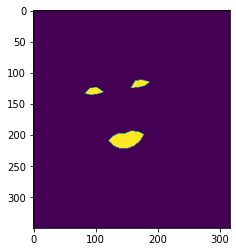

In [8]:
plt.imshow(mask)
plt.show()

## Crop Image

In [155]:
#bitwise_and 함수는 uint8과 uchar만 지원
cropedImg = cv2.bitwise_and(np.uint8(img), np.uint8(img), mask = np.uint8(mask))

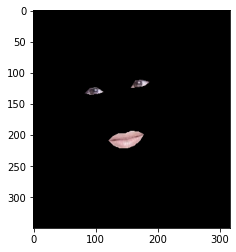

In [156]:
plt.imshow(cropedImg)
plt.show()

## Get Fruit

In [224]:
fruit = "lemon"

In [225]:
fruitImg = cv2.imread(rf"shapes\{fruit}.png", cv2.IMREAD_UNCHANGED)
fruitImg = cv2.cvtColor(fruitImg, cv2.COLOR_BGRA2RGBA)

## Fit Angle and Size of Fruit

원본 이미지에 과일 이미지를 정확하게 붙여넣기 위해서, 원본 이미지의 두 눈을 이은 직선을 만들어 해당 직선의 **길이**와 **각도**를 얻습니다.

이를 이용해 과일 이미지의 크기와 각도를 수정합니다.


**왼쪽 눈 끝** 20

**오른쪽 눈 끝** 29

### Angle

In [226]:
num_eyeLine = [19, 28]
vector_eyeLine = np.array(makeList(num_eyeLine)[0]) # makeList 함수가 Matrix를 반환해서 [0]만
eyeX, eyeY = (vector_eyeLine[1][0] - vector_eyeLine[0][0], vector_eyeLine[1][1] - vector_eyeLine[0][1])
vector_base = np.array([1, 0], dtype=np.int32)
vector_line = np.array([eyeX, eyeY], dtype=np.int32)

# 내적 값을 길이(norm)로 나눔 > cos(angle) > arccos 씌워서 angle 반환
getAngle = lambda x, y: np.arccos(np.inner(x, y) / (np.linalg.norm(x) * np.linalg.norm(y)))

# radians to degrees
angle = math.degrees(getAngle(vector_base, vector_line))
print(angle)

9.912751446723874


### Size

In [227]:

fruitX, fruitY, fruitC = fruitImg.shape

In [228]:
getSize = lambda x: np.linalg.norm(x)
size = getSize(vector_line)
scale = size * 2 / fruitY
print(scale)

0.15513499553183338


In [229]:
rotationMat = cv2.getRotationMatrix2D((fruitX/2, fruitY/2), angle, scale)

In [230]:
fruitX = fruitX * scale
fruitY = fruitY * scale

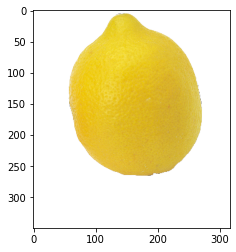

In [231]:
center = keyPoints[12]

rotationMat[1][2] = center[1] - fruitX / 2
rotationMat[0][2] = center[0] - fruitY / 2
fruitImgDst = cv2.warpAffine(fruitImg, rotationMat, (imgY, imgX))

plt.imshow(fruitImgDst)
plt.show()

## Image Addition

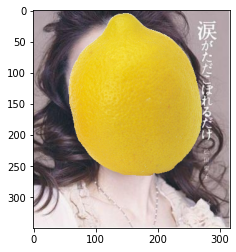

In [232]:
fore = fruitImgDst
back = img

_, _mask = cv2.threshold(fore[:, :, 3], 125, 255, cv2.THRESH_BINARY)
_mask_inv = cv2.bitwise_not(_mask)
fore = cv2.cvtColor(fore, cv2.COLOR_RGBA2RGB)

maskFore = cv2.bitwise_and(fore, fore, mask=_mask)
maskBack = cv2.bitwise_and(back, back, mask=_mask_inv)

dst = maskFore + maskBack

plt.imshow(dst)
plt.show()

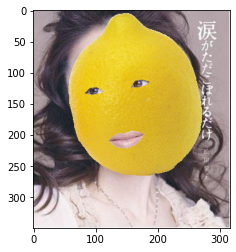

In [233]:
fore = cropedImg
back = dst

mask_inv = cv2.bitwise_not(mask)
fore = cv2.cvtColor(fore, cv2.COLOR_RGBA2RGB)

maskFore = cv2.bitwise_and(np.uint8(fore), np.uint8(fore), mask=np.uint8(mask))
maskBack = cv2.bitwise_and(np.uint8(back), np.uint8(back), mask=np.uint8(mask_inv))

dst = maskFore + maskBack

plt.imshow(dst)
plt.show()